2018 Nov 1<br>
This notebook contains the final, published analysis of the Kepler lightcurves for the Kepler-76 system. 

In [18]:
%matplotlib inline
#%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from numpy.random import normal

from PyAstronomy.modelSuite import forTrans as ft
from PyAstronomy.pyasl import isInTransit

from lightkurve import KeplerLightCurveFile

from evilmc import evparams, evmodel, convert_Kz
from transit_utils import *
from variable_eclipses_utils import retreive_data, fit_transit

from scipy.signal import lombscargle

from lmfit import minimize, Parameters

from variable_eclipses_utils import *
from BEER_curve import BEER_curve

K76 = Kepler76_params()

exp_time = 30./60./24.

# Official Boise State colors - https://brandstandards.boisestate.edu/colors/
BoiseState_blue = '#0033A0'
BoiseState_orange = '#D64309'

aspect_ratio = 16./9

Make plot of eclipse depth vs. num_periods to condition data

In [3]:
# Calculate BEER_curve
def calc_BEER_curve(time, params, exp_time=K76.exp_time, supersample_factor=K76.supersample_factor):
    BC = BEER_curve(time, params, exp_time=exp_time, supersample_factor=supersample_factor)
    return BC.all_signals()

def residuals(params, time, data, eps_data, model_to_use=calc_BEER_curve, 
              exp_time=K76.exp_time, supersample_factor=K76.supersample_factor):
    model = model_to_use(time, params, exp_time=exp_time, supersample_factor=supersample_factor)
    
    return (data - model) / eps_data

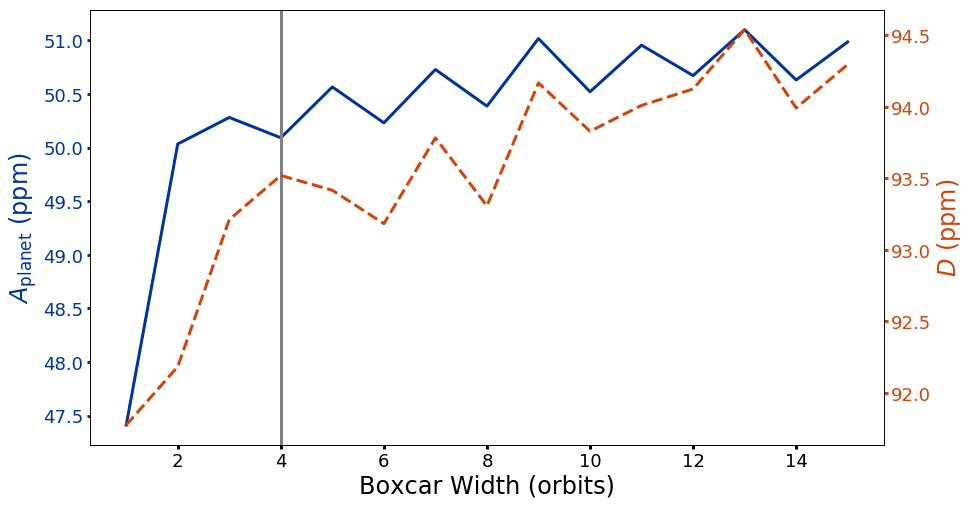

In [3]:
params = Parameters()

# Use best-fit values from Faigler et al. (2013)
params.add('per', value=K76.per.to('day').value, vary=False)
params.add('a', value=K76.a, vary=False)
params.add('b', value=K76.b, vary=False)
params.add('T0', value=K76.T0, vary=False)
params.add('baseline', value=0., min=-1000e-6, max=1000e-6)
params.add('Aellip', value=21e-6, min=-1000e-6, max=1000e-6)
params.add('Abeam', value=13e-6, min=-1000e-6, max=1000e-6)
params.add('Aplanet', value=60e-6, min=-1000e-6, max=1000e-6)
params.add('phase_shift', value=0., min=-1000e-6, max=1000e-6)
params.add('eclipse_depth', value=89e-6, min=-1000e-6, max=1000e-6)

trial_num_periods = range(1, 16)
eclipse_depths = np.array([])
eclipse_depths_errs = np.array([])
Aplanets = np.array([])
Aplanets_errs = np.array([])
redchis = np.array([])

for i in range(len(trial_num_periods)):

# Retrieve while masking out transit
    unfiltered_time, unfiltered_flux, filtered_time, filtered_flux = retreive_data(K76.saved_ep.per, num_periods=trial_num_periods[i], 
                                                             KIC=K76.KIC, fit_bottom=True, params=K76.saved_ep, 
                                                             drop_outliers=True)
    folded_time = filtered_time % K76.saved_ep.per

    # Grab the out-of-transit portion
    ind = ~transit_indices(folded_time, 2.*K76.dur, K76.T0)

    time = folded_time[ind]
    data = filtered_flux[ind]
    err = np.ones_like(data) # Don't worry about scatter.
    
    out = minimize(residuals, params, args=(time, data, err), kws={'model_to_use': calc_BEER_curve})

    eclipse_depths = np.append(eclipse_depths, out.params['eclipse_depth'].value)
    eclipse_depths_errs = np.append(eclipse_depths_errs, out.params['eclipse_depth'].stderr)
    
    Aplanets = np.append(Aplanets, out.params['Aplanet'].value)
    Aplanets_errs = np.append(Aplanets_errs, out.params['Aplanet'].stderr)
    
    redchis = np.append(redchis, out.redchi)

NameError: name 'trial_num_periods' is not defined

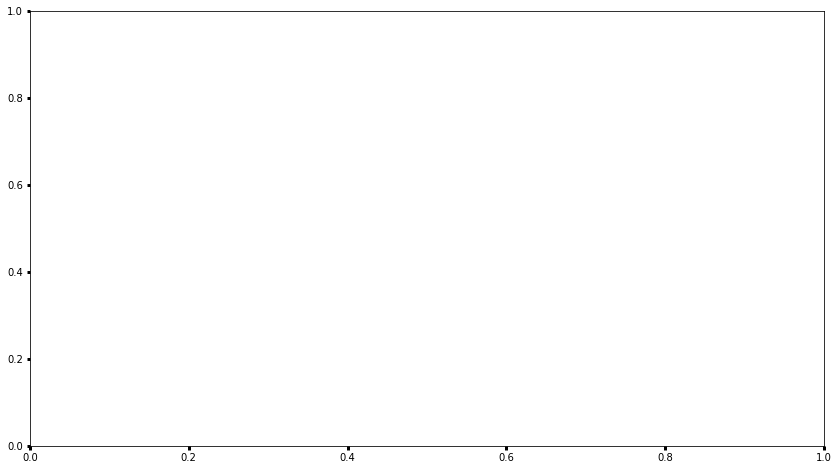

In [7]:
num_periods = 4

fig = plt.figure(figsize=(aspect_ratio*8, 8))

ax1 = fig.add_subplot(111)
ax1.plot(trial_num_periods, Aplanets*1e6, lw=3, color=BoiseState_blue)
ax1.set_xlabel("Boxcar Width (orbits)", fontsize=24)
ax1.set_ylabel("$A_{\\rm planet}$ (ppm)", color=BoiseState_blue, fontsize=24)
ax1.tick_params('y', colors=BoiseState_blue, labelsize=18)
ax1.tick_params('x', labelsize=18)

ax2 = ax1.twinx()
ax2.plot(trial_num_periods, eclipse_depths*1e6, lw=3, color=BoiseState_orange, ls='--')
ax2.set_ylabel("$D$ (ppm)", color=BoiseState_orange, fontsize=24)
ax2.tick_params('y', colors=BoiseState_orange, labelsize=18)

ax2.axvline(4, lw=3, zorder=-1, color='grey')

2018 Nov 5 - Plot of raw and conditioned data

In [8]:
unfiltered_time, unfiltered_flux, filtered_time, filtered_flux = retreive_data(K76.saved_ep.per, 
                                                                               num_periods=num_periods, 
                                                                               KIC=K76.KIC, fit_bottom=True, 
                                                                               params=K76.saved_ep, drop_outliers=True)
folded_time = filtered_time % K76.saved_ep.per

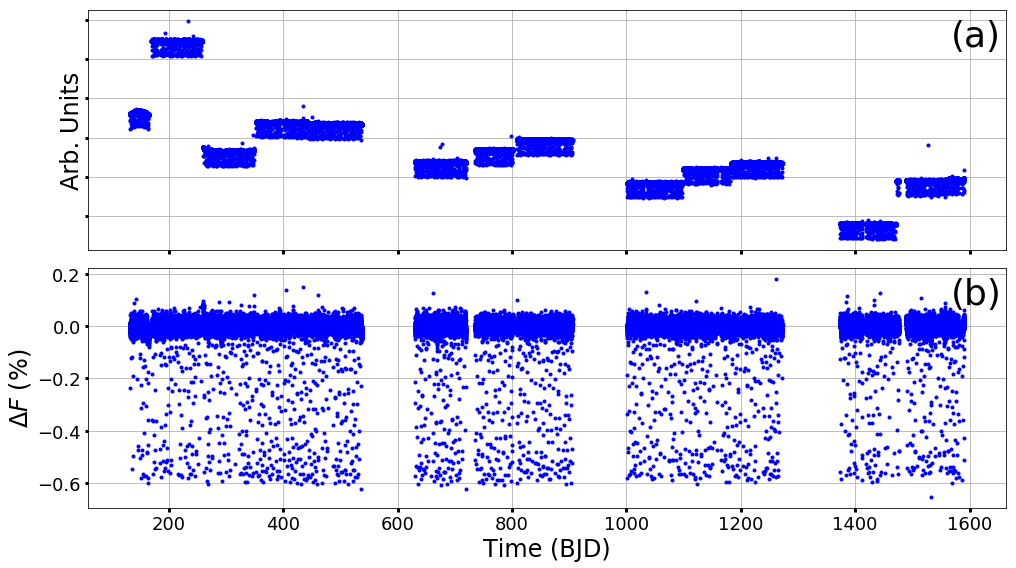

In [117]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))

ax1 = fig.add_subplot(211)
ax1.grid(True)
ax1.plot(unfiltered_time, unfiltered_flux, 'b.')
ax1.tick_params(labelbottom=False, labelleft=False)
ax1.annotate("(a)", xy=(0.9, 0.9), xytext=(0.94, 0.85), xycoords='axes fraction', textcoords='axes fraction',
             fontsize=36, arrowprops=None)
ax1.set_ylabel("Arb. Units", fontsize=24)

ax2 = fig.add_subplot(212)
ax2.grid(True)
ax2.plot(filtered_time, filtered_flux*100, 'b.')
ax2.annotate("(b)", xy=(0.9, 0.9), xytext=(0.94, 0.85), xycoords='axes fraction', textcoords='axes fraction',
             fontsize=36, arrowprops=None)
ax2.set_xlabel("Time (BJD)", fontsize=24)
ax2.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax2.tick_params('both', labelsize=18)

plt.tight_layout()

fig.savefig("../raw-conditioned-data_Analysis_of_Kepler76b.png", dpi=500, bbox_inches='tight')

---
Initial fit to just the transit portion using the best-fit orbital period from Faigler et al. (2013) and the Levenberg-Marquardt algorithm

In [35]:
# Fit folded transit
initial_transit_params = Parameters()

# Use best-fit values from Faigler et al. (2013)
initial_transit_params.add('per', value=K76.per.to('day').value, vary=False)
initial_transit_params.add('a', value=K76.a, min=2., max=10.)
initial_transit_params.add('p', value=K76.Rp_over_Rs, min=0., max=0.2)
initial_transit_params.add('b', value=K76.b, min=-1., max=1.)
initial_transit_params.add('T0', value=K76.T0, min=K76.T0*0.95, max=K76.T0*1.05)
initial_transit_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)

# Holding LDCs fixed at Faigler et al. (2013) values because I can't generate useful constraints on them
initial_transit_params.add('linLimb', value=K76.coeffs[0], vary=False)
initial_transit_params.add('quadLimb', value=K76.coeffs[1], vary=False)

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])

time = folded_time[transit_ind]
data = filtered_flux[transit_ind]
# Initial estimate of scatter
err = mad(filtered_flux[~transit_ind])*np.ones_like(time)

out = minimize(residuals, initial_transit_params, args=(time, data, err), kws={'model_to_use': fit_transit})
print(out.params.pretty_print())
print(out.redchi)

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           0.685   0.6508   0.7193 2.606e-05     True     None     None
a            5.114        2       10  0.05485     True     None     None
b           0.9072       -1        1 0.002853     True     None     None
baseline  -4.458e-05   -0.001    0.001 5.012e-06     True     None     None
linLimb      0.313     -inf      inf        0    False     None     None
p          0.08464        0      0.2 0.0005146     True     None     None
per          1.545     -inf      inf        0    False     None     None
quadLimb     0.304     -inf      inf        0    False     None     None
None
1.2773525731038515


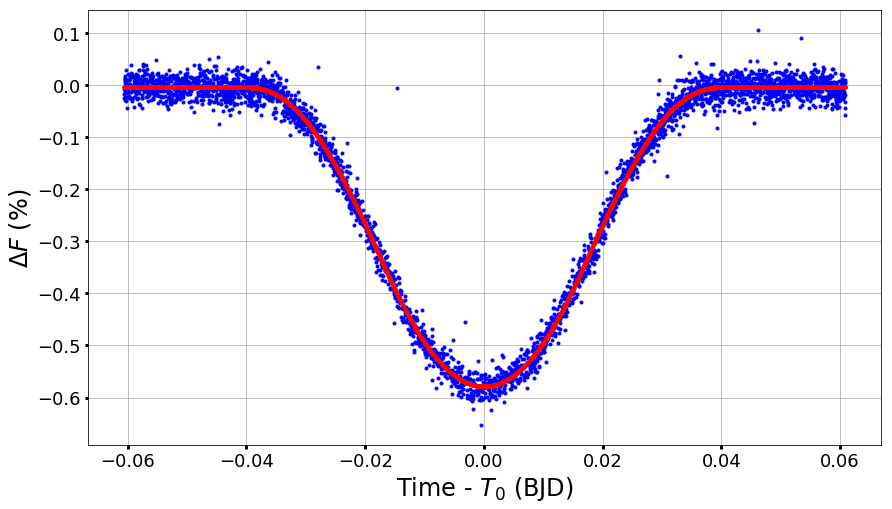

In [50]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))
ax = fig.add_subplot(111)
ax.grid(True)
ax.plot(time - out.params['T0'], data*100, 'b.')
ax.plot(time - out.params['T0'], fit_transit(time, out.params)*100, 'r.')
ax.set_xlabel("Time - $T_{\\rm 0}$ (BJD)", fontsize=24)
ax.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax.tick_params('both', labelsize=18)

In [48]:
# Checking how the fit parameters vary if I use limb-darkening coefficients from Espinoza & Jordan (2015)
# http://adsabs.harvard.edu/abs/2015MNRAS.450.1879E

# Use best-fit values from Faigler et al. (2013)
initial_transit_params.add('per', value=K76.per.to('day').value, vary=False)
initial_transit_params.add('a', value=K76.a, min=2., max=10.)
initial_transit_params.add('p', value=K76.Rp_over_Rs, min=0., max=0.2)
initial_transit_params.add('b', value=K76.b, min=-1., max=1.)
initial_transit_params.add('T0', value=K76.T0, min=K76.T0*0.95, max=K76.T0*1.05)
initial_transit_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)

# From Kepler76_output_file.dat - 
# Kepler-76  A100  KpHiRes
# Teff=6250.0K  log(g)=4.0  [M/H]=-0.1  vturb=2.0
initial_transit_params['linLimb'].value = 0.32587116
initial_transit_params['quadLimb'].value = 0.30272132

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])

time = folded_time[transit_ind]
data = filtered_flux[transit_ind]
# Initial estimate of scatter
err = mad(filtered_flux[~transit_ind])*np.ones_like(time)

out = minimize(residuals, initial_transit_params, args=(time, data, err), kws={'model_to_use': fit_transit})
print(out.params.pretty_print())
print(out.redchi)

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           0.685   0.6508   0.7193 2.606e-05     True     None     None
a            5.114        2       10  0.05474     True     None     None
b           0.9069       -1        1 0.002866     True     None     None
baseline  -4.433e-05   -0.001    0.001 5.013e-06     True     None     None
linLimb     0.3259     -inf      inf        0    False     None     None
p          0.08488        0      0.2 0.0005234     True     None     None
per          1.545     -inf      inf        0    False     None     None
quadLimb    0.3027     -inf      inf        0    False     None     None
None
1.2772928754771382


In [49]:
# Checking how the fit parameters vary if I use limb-darkening coefficients from Espinoza & Jordan (2015)
# http://adsabs.harvard.edu/abs/2015MNRAS.450.1879E

# Use best-fit values from Faigler et al. (2013)
initial_transit_params.add('per', value=K76.per.to('day').value, vary=False)
initial_transit_params.add('a', value=K76.a, min=2., max=10.)
initial_transit_params.add('p', value=K76.Rp_over_Rs, min=0., max=0.2)
initial_transit_params.add('b', value=K76.b, min=-1., max=1.)
initial_transit_params.add('T0', value=K76.T0, min=K76.T0*0.95, max=K76.T0*1.05)
initial_transit_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)

# From Kepler76_output_file.dat - 
# Kepler-76  P100  KpHiRes
# Teff=6300.0K  log(g)=4.0  [M/H]=0.0  vturb=2.0
initial_transit_params['linLimb'].value = 0.44916238
initial_transit_params['quadLimb'].value = 0.19578540

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])

time = folded_time[transit_ind]
data = filtered_flux[transit_ind]
# Initial estimate of scatter
err = mad(filtered_flux[~transit_ind])*np.ones_like(time)

out = minimize(residuals, initial_transit_params, args=(time, data, err), kws={'model_to_use': fit_transit})
print(out.params.pretty_print())
print(out.redchi)

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           0.685   0.6508   0.7193 2.606e-05     True     None     None
a            5.141        2       10  0.05574     True     None     None
b           0.9055       -1        1 0.002953     True     None     None
baseline  -4.417e-05   -0.001    0.001 5.019e-06     True     None     None
linLimb     0.4492     -inf      inf        0    False     None     None
p          0.08573        0      0.2 0.0005419     True     None     None
per          1.545     -inf      inf        0    False     None     None
quadLimb    0.1958     -inf      inf        0    False     None     None
None
1.2772196299273708


At least according to Levenberg-Marquardt, I get the same transit parameters (to within uncertainties) for all three sets of limb-darkening parameters.

---

(0.6, 0.8)

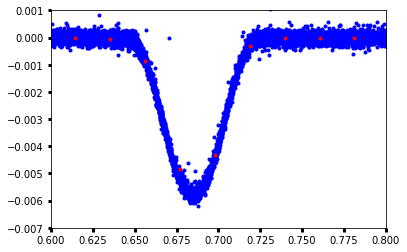

In [5]:
# Initial fit using Faigler's parameters (with my own T0)
plt.plot(folded_time, filtered_flux, 'b.')
plt.plot(binned_time, binned_flux, 'r.')

# em = evmodel(binned_time, saved_ep, supersample_factor=100, exp_time=30./60./24.)
# sig = em.all_signals()
# plt.plot(binned_time, sig, 'r.')

plt.ylim([-0.007, 0.001])
plt.xlim([0.6, 0.8])
# #plt.xlim([1.4, 1.6])
# plt.axhline(fit_eclipse_bottom(binned_time, binned_flux, saved_ep), color='red')

[0.001590990389948875, 1.0273774132103083e-06, 6.04e-05, 6.04e-05, -0.02861111111111111]
[ 3.11818871e-03  1.47963266e-11  3.20044132e-05  4.76595415e-05
 -3.46843119e-02]
[2.61508143e-04 6.85559293e-02 1.52179792e-06 3.66377909e-02
 5.52502829e+02]


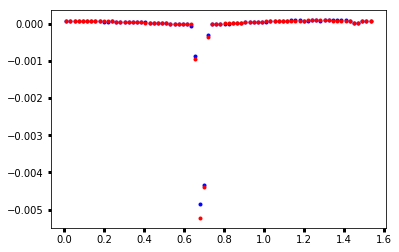

In [7]:
# 2018 Sep 6 - An initial attempt to fit the EV+ signals without fitting the transit
# Fit the EVIL-MC curve, holding constant the transit parameters
def fit_EVILMC(time, cur_q, cur_Kz, cur_F0, cur_Aplanet, cur_phase_shift):
    cur_ep = evparams(per=saved_ep.per, a=saved_ep.a, T0=saved_ep.T0, p=saved_ep.p, limb_dark="quadratic", 
                      b=saved_ep.b, beta=saved_ep.beta, Ts=Ts, Ws=[0.,0.,Omegas], u=coeffs,
                      q=cur_q, Kz=cur_Kz, F0=cur_F0, Aplanet=cur_Aplanet, phase_shift=cur_phase_shift)
    
    em = evmodel(time, cur_ep, supersample_factor=10, exp_time=binsize)
    
    return em.all_signals()

# Focus on the out-of-transit/eclipse points alone
dur = transit_duration(saved_ep)
ind = ~(isInTransit(binned_time, saved_ep.T0, saved_ep.per, dur, boolOutput=True) |
        isInTransit(binned_time, saved_ep.T0 + 0.5*saved_ep.per, saved_ep.per, dur, boolOutput=True))

time = binned_time[ind]
data = binned_flux[ind]
err = binned_err[ind]

initial_guess = [saved_ep.q, saved_ep.Kz, saved_ep.F0, saved_ep.Aplanet, saved_ep.phase_shift]
ev_popt, ev_pcov = curve_fit(fit_EVILMC, time, data,
                       p0=initial_guess, sigma=err,
                       bounds=([0., 0., -100e-6, -100e-6, -1.], [0.1, 1e-5, 100e-6, 100e-6, 1.]))
print(initial_guess)
print(ev_popt)
print(np.sqrt(ev_pcov.diagonal()))

# Plotting residuals - Clearly not a perfect fit!
plt.plot(binned_time, binned_flux, 'b.')
plt.plot(binned_time, fit_EVILMC(binned_time, *ev_popt), 'r.')

[1.0, 0.7066812502235398, 4.524886877828054, 0.09683257918552035, 78.0]
[ 1.00000086  0.68500134  4.99611595  0.08587606 79.46970712]
[2.25651660e-06 1.99353689e-05 3.92840299e-02 5.05183439e-04
 1.09566775e-01]
(<Quantity 0.00028359>, <Quantity 169.55255744>)
5.923400309711936


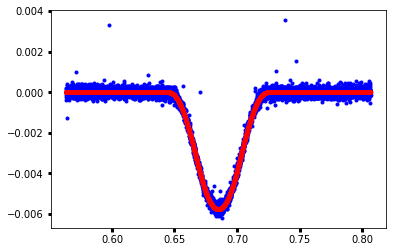

In [15]:
def fit_transit(time, baseline, T0, a, p, cur_inc):
    model = ft.MandelAgolLC(orbit="circular", ld="quad")

    # Set parameters
    model["per"] = saved_ep.per
    model["i"] = cur_inc
    model["a"] = a
    model["T0"] = T0
    model["p"] = p
    model["linLimb"] = coeffs[0]
    model["quadLimb"] = coeffs[1]
    model["b"] = 0.

    supersample_factor = 10
    exp_time = 30./60./24.
    
    # Consider finite exposure time
    time_supersample = time
    if(supersample_factor > 1):
        time_offsets = np.linspace(-exp_time/2., exp_time/2., supersample_factor)
        time_supersample = (time_offsets + time.reshape(time.size, 1)).flatten()
    
    ret = model.evaluate(time_supersample)
    
    if(supersample_factor > 1):
        ret = np.mean(ret.reshape(-1, supersample_factor), axis=1)
        
    ret -= baseline
        
    return ret

# Focus on the out-of-transit/eclipse points alone
dur = transit_duration(saved_ep, which_duration='full')
ind = isInTransit(folded_time, saved_ep.T0, saved_ep.per, 2.*dur, boolOutput=True)

time = folded_time[ind]
data = filtered_flux[ind]

# cur_ep = evparams(per=saved_ep.per, a=saved_ep.a, T0=saved_ep.T0, p=0., limb_dark="quadratic", b=saved_ep.b, 
#                   beta=saved_ep.beta, Ts=Ts, Ws=[0.,0.,Omegas], u=coeffs,
#                   q=ev_popt[0], Kz=ev_popt[1], F0=ev_popt[2], Aplanet=ev_popt[3], phase_shift=ev_popt[4])
# em = evmodel(time, cur_ep, supersample_factor=10, exp_time=30./60./24.)
# sig = em.all_signals()

data = data - sig

initial_guess = [1., Faigler_T0, saved_ep.a, saved_ep.p, inc]
# trans_popt, trans_pcov = curve_fit(fit_transit, time, data,
#                        p0=initial_guess, 
#                        bounds=([1 - 0.01, Faigler_T0 - 0.2, 2., 0., 70.], 
#                                [1 + 0.01, Faigler_T0 + 0.2, 5., 0.2, 100.]))
print(initial_guess)
print(trans_popt)
print(np.sqrt(trans_pcov.diagonal()))

plt.plot(time, data, 'b.')
plt.plot(time, fit_transit(time, *trans_popt), 'r.')

resid = data - fit_transit(time, *trans_popt)
print(np.mean(resid)*1e6, np.std(resid)*1e6)
resid_binned_time, resid_binned_resid, resid_binned_err = bindata(time, resid, binsize)
print(np.std(resid_binned_resid)*1e6)

#plt.plot(time, data - fit_transit(time, *trans_popt), 'b.')
#print(np.max(np.abs(data - fit_transit(time, *trans_popt)))*1e6)

# plt.plot(resid_binned_time, resid_binned_resid)
# print(np.max(np.abs(resid_binned_resid)))

# cur_ep = evparams(per=saved_ep.per, a=trans_popt[2], T0=trans_popt[1], p=trans_popt[3], limb_dark="quadratic", 
#                   b=trans_popt[2]*np.cos(trans_popt[4]*np.pi/180.), beta=saved_ep.beta, Ts=Ts, Ws=[0.,0.,Omegas], 
#                   u=coeffs, q=ev_popt[0], Kz=ev_popt[1], F0=ev_popt[2], Aplanet=ev_popt[3], phase_shift=ev_popt[4])
# dur = transit_duration(cur_ep, which_duration='full')
# plt.axvline(trans_popt[1] - 0.5*dur)
# plt.axvline(trans_popt[1] + 0.5*dur)

[0.7066812502235398, 4.524886877828054, 0.09683257918552035, 0.944]
[0.68537455 4.43005459 0.07367425 0.93054965]
[0.00026662 0.01518546 0.00126759 0.00329213]
42.4964010732


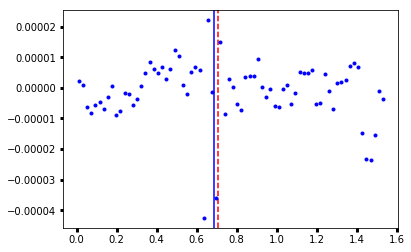

In [16]:
# Faigler's mid-transit time seems a little off. We fit a T0 value for the folded data below.
def fit_signal(time, T0, a, p, b):
    cur_ep = evparams(per=saved_ep.per, a=saved_ep.a, T0=saved_ep.T0, p=0., limb_dark="quadratic", b=saved_ep.b, 
                  beta=saved_ep.beta, Ts=Ts, Ws=[0.,0.,Omegas], u=coeffs,
                  q=ev_popt[0], Kz=ev_popt[1], F0=ev_popt[2], Aplanet=ev_popt[3], phase_shift=ev_popt[4])
    
    cur_ep.T0 = T0
    cur_ep.a = a
    cur_ep.p = p
    cur_ep.b = b
    
    em = evmodel(time, cur_ep, supersample_factor=100, exp_time=30./60./24.)
    
    return em.all_signals()

time = binned_time
data = binned_flux
err = binned_err

initial_guess = [Faigler_T0, saved_ep.a, saved_ep.p, saved_ep.b]
trans_popt, trans_pcov = curve_fit(fit_signal, time, data,
                       p0=initial_guess, sigma=err,
                       bounds=([Faigler_T0 - 0.1, 2., 0., -1], 
                               [Faigler_T0 + 0.1, 5., 0.2, 1]))
print(initial_guess)
print(trans_popt)
print(np.sqrt(trans_pcov.diagonal()))

# Update parameter
# print(saved_ep.T0)
# ep = deepcopy(saved_ep)
# ep.T0 = popt[0]
# ep.a = popt[1]
# ep.p = popt[2]
# ep.b = popt[3]

#plt.plot(binned_time, binned_flux, 'b.')

# Faigler's T0 in read, the new one blue
plt.axvline(trans_popt[0], color='blue')
plt.axvline(Faigler_T0, color='red', ls='--')

# Plotting residuals - Clearly not a perfect fit!
# plt.plot(binned_time, binned_flux, 'b.')
# plt.plot(binned_time, fit_signal(binned_time, *trans_popt), color='red')

plt.plot(time, data - fit_signal(time, *trans_popt), 'b.')
print(np.max(np.abs(data - fit_signal(time, *trans_popt)))*1e6)

(-0.0015, 0.0015)

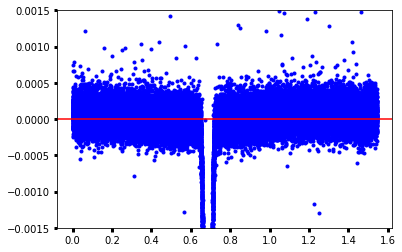

In [43]:
# Now re-retrieve data, masking out transit as data are filtered.
time, flux, filtered_time, filtered_flux = retreive_data(ep.per, num_periods=num_period, 
                                                         KIC=KIC, params=ep, fit_bottom=True)
folded_time = filtered_time % ep.per

binned_time, binned_flux, binned_err = bindata(folded_time, filtered_flux, binsize=binsize)
#plt.plot(folded_time, filtered_flux, 'b.')
plt.plot(folded_time, filtered_flux, 'b.')
plt.axhline(0, color='red')
plt.ylim([-0.0015, 0.0015])

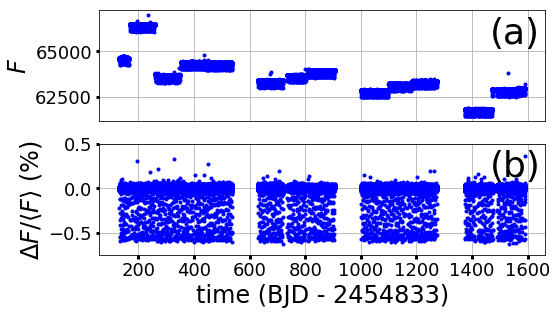

In [19]:
fig = plt.figure(figsize=(8, 4.5))

ax1 = fig.add_subplot(211)
ax1.tick_params(which='both', labelbottom=False, bottom=False)
ax1.tick_params(which='major', axis='y', labelsize=18)
ax1.grid(True)
ax1.set_ylabel("$F$", fontsize=24)
ax1.annotate("(a)", xy=(0.875, 0.7), xytext=(0.875, 0.7), fontsize=36, xycoords='axes fraction')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.grid(True)
ax2.set_xlabel("time (BJD - 2454833)", fontsize=24)
ax2.set_ylabel("$\Delta F/\\langle F \\rangle$ (%)", fontsize=24)
ax2.tick_params(which='both', labelsize=18)
ax2.annotate("(b)", xy=(0.875, 0.7), xytext=(0.875, 0.7), fontsize=36, xycoords='axes fraction')

# for q in range(0, 18):
KIC = 4570949
base_dir = "mastDownload/Kepler/"
time, flux, filtered_time, filtered_flux = retreive_data(per.to('day').value, params=ep)

ax1.plot(time, flux, 'b.')
ax2.plot(filtered_time, filtered_flux*100, 'b.')
ax2.set_ylim([-0.75, 0.5])

fig.savefig('Analysis_of_Kepler76b_data.jpg', dpi=500, bbox_inches='tight')

T0: 2454966.54887 +- 8e-05, Period: 1.5449288 +- 1e-07; BIC: 13.2113
a, b, c: 6.44186e-11 +- 4.21262e-10, 1.54493 +- 4.15539e-07, 132.004 +- 9.51374e-05; BIC: 19.6397


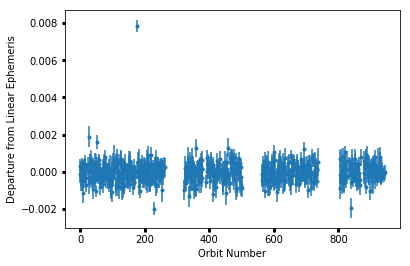

In [18]:
# Check transit ephemeris using ONLY the transit signal, not evilmc, just to speed up the calculation
def fit_signal(time, T0, supersample_factor=10, exp_time=30./60./24.):
    model = ft.MandelAgolLC(orbit="circular", ld="quad")

    # Set parameters
    model["per"] = ep.per
    model["i"] = inc
    model["a"] = ep.a
    model["T0"] = T0
    model["p"] = ep.p
    model["linLimb"] = ep.u[0]
    model["quadLimb"] = ep.u[1]
    model["b"] = 0.

    # Consider finite exposure time
    time_supersample = time
    if(supersample_factor > 1):
        time_offsets = np.linspace(-exp_time/2., exp_time/2., supersample_factor)
        time_supersample = (time_offsets + time.reshape(time.size, 1)).flatten()
    
    ret = model.evaluate(time_supersample)
    
    if(supersample_factor > 1):
        ret = np.mean(ret.reshape(-1, supersample_factor), axis=1)
        
    ret -= 1.
        
    return ret

def fit_line(x, m, b):
    return m*x + b

def fit_quad(x, a, b, c):
    return a*x**2 + b*x + c

# Collect each orbit, one at a time and fit mid-transit time
midtransit_times = np.array([])
midtransit_times_err = np.array([])

cur_orb = -1
num_orb = np.array([])
num_points_in_transit = np.array([])
ind = (filtered_time >= np.min(filtered_time)) & (filtered_time < np.min(filtered_time) + ep.per)
time = filtered_time[ind]
mn_time = np.min(time)

while(mn_time <= np.max(filtered_time)):
#while(mn_time <= np.min(filtered_time) + 100.*ep.per):
    
    ind = (filtered_time >= mn_time) & (filtered_time < mn_time + ep.per)
    mn_time += ep.per
    cur_orb += 1
    
    # Fewer than 70 points, and the mid-transit time fit is awful
    if(len(ind[ind]) <= 70):
        continue
       
    time = filtered_time[ind]
    flux = filtered_flux[ind]
    
    # Mask the transit and estimate uncertainties from standard deviation of remaining points
    folded_time = time % ep.per
    dur = transit_duration(ep)
    non_transit_ind = ~isInTransit(folded_time, T0, ep.per, 0.5*dur, boolOutput=True)
    err = np.ones_like(flux)*mad(flux[non_transit_ind])
    
    initial_guess = time[np.argmin(flux)]
    popt, pcov = curve_fit(fit_signal, time, flux, sigma=err, p0=initial_guess, 
                       bounds=(np.min(time), np.max(time)))
    
    # Calculate reduced chi-squared
    chisq = np.sum(((flux - fit_signal(time, *popt))/err)**2.)/(len(flux) - 1.)
    
    # Make sure there are at least three points in transit
    dur = transit_duration(ep)
    transit_ind = isInTransit(folded_time, popt[0], ep.per, 0.5*dur)
    if(len(time[transit_ind]) < 3):
        continue
    
    num_orb = np.append(num_orb, cur_orb)
    midtransit_times = np.append(midtransit_times, popt[0])
    midtransit_times_err = np.append(midtransit_times_err, np.sqrt(pcov[0]/chisq))

# Fit straight line to mid-transit times
lin_popt, lin_pcov = curve_fit(fit_line, num_orb, midtransit_times, sigma=midtransit_times_err)
# Calculate chi-squared and BIC
lin_fit = fit_line(num_orb, *lin_popt)
lin_chisq = np.sum((midtransit_times - lin_fit)/midtransit_times_err)**2./(len(num_orb) - 2.)
lin_BIC = lin_chisq + len(lin_popt)*np.log(len(num_orb))

# Rescale uncertainties to drive chi-squared to unity.
#   To shift T0 closer to the value reported in Faigler+ (2013), add one orbital period.
print("T0: %.5f +- %.1g, Period: %.7f +- %.1g; BIC: %g" % (lin_popt[1] + 2454833. + lin_popt[0], 
                                                           np.sqrt(lin_pcov[1,1]/lin_chisq), 
                                                           lin_popt[0], np.sqrt(lin_pcov[0,0]/lin_chisq), lin_BIC))

plt.errorbar(num_orb, midtransit_times - fit_line(num_orb, *lin_popt), midtransit_times_err, ls='', marker='.')
plt.xlabel('Orbit Number')
plt.ylabel('Departure from Linear Ephemeris')

# Fit quadratic to mid-transit times
quad_popt, quad_pcov = curve_fit(fit_quad, num_orb, midtransit_times, sigma=midtransit_times_err)
# Calculate chi-squared and BIC
quad_fit = fit_quad(num_orb, *quad_popt)
quad_chisq = np.sum((midtransit_times - quad_fit)/midtransit_times_err)**2./(len(num_orb) - 2.)
quad_BIC = quad_chisq + len(quad_popt)*np.log(len(num_orb))

# Rescale uncertainties to drive chi-squared to unity for quad model.
print("a, b, c: %g +- %g, %g +- %g, %g +- %g; BIC: %g" % (quad_popt[0], np.sqrt(quad_pcov[0,0]/quad_chisq),
                                                        quad_popt[1], np.sqrt(quad_pcov[1,1]/quad_chisq),
                                                        quad_popt[2], np.sqrt(quad_pcov[2,2]/quad_chisq),
                                                        quad_BIC))

# And finally check for any periodic signals -
#  https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
nout = 10000
min_freq = 1./np.min(midtransit_times[1:] - midtransit_times[0:-1])
max_freq = 1./(np.max(midtransit_times) - np.min(midtransit_times[0:-1]))
f = np.linspace(min_freq, max_freq, nout)
pgram = lombscargle(midtransit_times, midtransit_times - lin_fit, f)

# Largest peak barely above the other peaks, suggesting no periodicity
# plt.plot(f, pgram)

ep.per = lin_popt[0]
#ep.T0 = lin_popt[1]

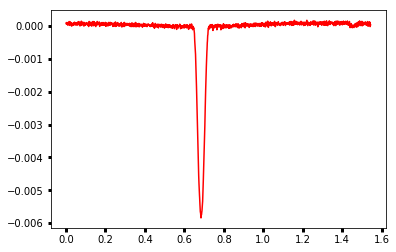

In [19]:
# Fit folded transit
time, flux, filtered_time, filtered_flux = retreive_data(ep.per, num_periods=num_period, 
                                                         KIC=KIC, params=ep)
folded_time = filtered_time % ep.per

binned_time, binned_flux, binned_err = bindata(folded_time, filtered_flux, binsize=binsize)
#plt.plot(folded_time, filtered_flux, 'b.')
plt.plot(binned_time, binned_flux, 'r')

In [32]:
def fit_transit(time, T0, inc, semi, p, supersample_factor=20, exp_time=30./60./24.):
    model = ft.MandelAgolLC(orbit="circular", ld="quad")

    # Set parameters
    model["per"] = ep.per
    model["i"] = inc
    model["a"] = semi
    model["T0"] = T0
    model["p"] = p
    model["linLimb"] = ep.u[0]
    model["quadLimb"] = ep.u[1]
    model["b"] = 0.

    # Consider finite exposure time
    time_supersample = time
    if(supersample_factor > 1):
        time_offsets = np.linspace(-exp_time/2., exp_time/2., supersample_factor)
        time_supersample = (time_offsets + time.reshape(time.size, 1)).flatten()
    
    ret = model.evaluate(time_supersample)
    
    if(supersample_factor > 1):
        ret = np.mean(ret.reshape(-1, supersample_factor), axis=1)
        
    ret -= 1.
        
    return ret

In [53]:
# Fit the EVIL-MC curve, holding constant the transit parameters
def fit_EVILMC(time, cur_q, cur_Kz, cur_F0, cur_Aplanet, cur_phase_shift):
    cur_ep = evparams(per=ep.per, a=ep.a, T0=ep.T0, p=ep.p, limb_dark="quadratic", b=ep.b, 
                      beta=ep.beta, Ts=Ts, Ws=[0.,0.,Omegas], u=coeffs,
                      q=cur_q, Kz=cur_Kz, F0=cur_F0, Aplanet=cur_Aplanet, phase_shift=cur_phase_shift)
    
    em = evmodel(time, cur_ep, supersample_factor=10, exp_time=30./60./24.)
    
    return em.all_signals()

[0.001590990389948875, 1.0273774132103083e-06, 5.04e-05, 5.04e-05, 0.02861111111111111]
(array([ 9.74648947e-03,  2.08464109e-06,  3.58181113e-05,  5.25429404e-05,
       -2.70447918e-02]), array([1.63534568e-03, 1.59607779e-04, 1.83162501e-06, 2.73593302e-05,
       4.82553932e-01]))


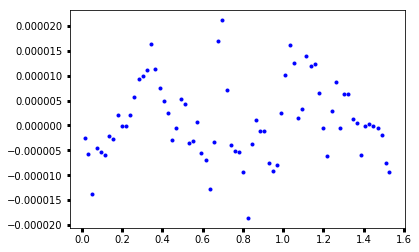

In [55]:
initial_guess = [ep.q, ep.Kz, ep.F0, ep.Aplanet, ep.phase_shift]

#%time popt, pcov = curve_fit(fit_EVILMC, binned_time, binned_flux, p0=initial_guess, bounds=([0., -1e-5, -100e-6, -100e-6, -1], [0.01, 1e-5, 100e-6, 100e-6, 1]))
print(initial_guess)
print(popt, np.sqrt(pcov.diagonal()))

# plt.plot(binned_time, binned_flux, 'b.')
# plt.plot(binned_time, fit_EVILMC(binned_time, *popt), 'r')

resid = binned_flux - fit_EVILMC(binned_time, *popt)

plt.plot(binned_time, resid, 'b.')

# binned_binned_time, binned_binned_resid, binned_binned_err = bindata(binned_time, resid, binsize=30./60./24.)
# plt.plot(binned_binned_time, binned_binned_resid, 'b.')

In [28]:
# Save all notebook results so I don't have to re-run everything every time I open the notebook.
dill.dump_session('Analysis_of_Kepler76b.db')